In [1]:
from contextlib import contextmanager
import matplotlib.pyplot as plt
import numpy as np
from nesopy.model import DockerModel
from nesopy.output import read_hdf5_datasets

In this notebook we illustrate how to use the `DockerModel` class in `nesopy.model` to execute and extract the outputs from runs of a NESO solver which has been built within a Docker image. We can view the docstring for the `DockerModel` class as below

In [2]:
DockerModel?

Init signature:
DockerModel(
    image_name: str,
    *args,
    container_setup_commands: collections.abc.Sequence = (),
    container_mount_path: str | pathlib.Path = '/output',
    **kwargs,
)
Docstring:      NESO model using solver installed in Docker image.
Init docstring:
Create a new Docker based NESO model wrapper instance.

Args:
    image_name: Name of Docker image in which NESO solvers are installed.
    solver_executable_path: Path to NESO solver executable to use.
    base_session_file_path: Path to XML file defining bae NESO configuration.
        Parameters values defined in this file are used as defaults unless
        overridden by `parameter_overrides` keyword arguments when calling
        model.
    mesh_file_path: Path to XML file defining spatial mesh to solve on.
    extract_outputs_function: Function to extract required outputs from model.
        This function is passed the path to the temporary directory any outputs
        from solver executable are written t

We see that one of the required arguments to `DockerModel` is a function to extract the required outputs from the model `extract_outputs_function`. Specifically here we will use a function which reads HDF5 files outputted by solver and extracts the relevant quantities as NumPy arrays. The `read_hdf5_datasets` helper function from `nesopy.output` provides a simple way of reading datasets at particular [paths](https://docs.hdfgroup.org/hdf5/develop/_h5_g__u_g.html#subsubsec_group_descr_path) or sequences of paths within a HDF5 file:

In [3]:
read_hdf5_datasets?

Signature: read_hdf5_datasets(hdf5_file_path: pathlib.Path, dataset_paths: dict) -> dict
Docstring:
Read one or more datasets at specified paths from a HDF5 file.

Args:
    hdf5_file_path: Path to HDF5 file to read dataset(s) from.
    dataset_paths: Map from string keys to one or more HDF5 paths to datasets within
       the HDF5 file to read. If a key is associated with a single HDF5 path then
       the returned dictionary will contain an entry for the key corresponding to
       the dataset specified by that path as a NumPy array. If a key is associated
       with a sequence of paths, then it is assumed all paths refer to HDF5 datasets
       of the same shape such that they can be stacked in an array with number of
       dimensions one more than each datasets number of dimensions, with the
       returned dictionary then containing an entry for the key corresponding to
       this stacked array, with first axis indexing across the dataset paths.

Returns:
    Dictionary of read

For our particular `extract_outputs` function we read HDF5 datasets from several different files, but if only a subset of outputs are required we would only need to read the files and datasets of interest.

In [4]:
def extract_outputs(output_directory, completed_process, parameters):
    num_steps = parameters["particle_num_time_steps"]
    final_line_field_step = range(
        0, num_steps, parameters["line_field_deriv_evaluations_step"]
    )[-1]
    field_trajectory_steps = range(
        0, num_steps, parameters["particle_num_write_field_energy_steps"]
    )
    return {
        "parameters": parameters,
        "line_field": read_hdf5_datasets(
            output_directory / "Electrostatic2D3V_line_field_evaluations.h5part",
            {
                "x": f"Step#{final_line_field_step}/x",
                "field_value": f"Step#{final_line_field_step}/FIELD_EVALUATION_0",
            },
        ),
        "line_field_derivative": read_hdf5_datasets(
            output_directory / "Electrostatic2D3V_line_field_deriv_evaluations.h5part",
            {
                "x": f"Step#{final_line_field_step}/x",
                "field_value": f"Step#{final_line_field_step}/FIELD_EVALUATION_0",
            },
        ),
        "field_trajectory": read_hdf5_datasets(
            output_directory / "Electrostatic2D3V_field_trajectory.h5",
            {
                "field_energy": [
                    f"step_data/{step}/field_energy" for step in field_trajectory_steps
                ],
                "kinetic_energy": [
                    f"step_data/{step}/kinetic_energy" for step in field_trajectory_steps
                ],
                "potential_energy": [
                    f"step_data/{step}/potential_energy" for step in field_trajectory_steps
                ],
            },
        ) | {"t": np.array(field_trajectory_steps) * parameters["particle_time_step"]}
    }

We define a helper function to plot line field evaluations from the extracted outputs:

In [5]:
def plot_line_field(axes, model_outputs, label=None):
    keys_and_ylabels = {
        "line_field": "Electrostatic potential $\phi(x)$", 
        "line_field_derivative": "Electrostatic potential derivative $\partial\phi(x)$", 
    }
    for ax, (key, ylabel) in zip(axes, keys_and_ylabels.items()):
        ax.plot(model_outputs["line_field"]["x"], model_outputs[key]["field_value"], label=label)
        ax.set(xlabel="Spatial coordinate $x$", ylabel=ylabel)

We also define a helper function to plot the extacted energy trajectory outputs:

In [6]:
def plot_energy_trajectories(axes, model_outputs, label=None):
    keys_and_ylabels = {
        "field_energy": "Field energy $E_f(t)$", 
        "potential_energy": "Potential energy $E_p(t)$", 
        "kinetic_energy": "Kinetic energy $E_k(t)$",
    }
    for ax, (key, ylabel) in zip(axes, keys_and_ylabels.items()):
        ax.plot(model_outputs["field_trajectory"]["t"], model_outputs["field_trajectory"][key], label=label)
        ax.set(xlabel="Time $t$", ylabel=ylabel)

And finally we define a context manager to deal with automatically closing and adjusting layout of Matplotlib figures.

In [7]:
@contextmanager
def autoclosing_subplots_with_tight_layout(*args, **kwargs):
    fig, axes = plt.subplots(*args, **kwargs)
    yield fig, axes
    fig.tight_layout()
    plt.show(fig)
    plt.close(fig)

We create an instance of the `DockerModel` class, passing in the `extract_outputs` function defined above as an argument. We also need to specify the name of [the Docker image in which we have built and installed NESO](https://github.com/ExCALIBUR-NEPTUNE/NESO#building-with-spack), the path to the built solver executable on the image (here we use the `Electrostatic2D3V` solver), paths to [Nektar++ XML session and mesh files](https://doc.nektar.info/userguide/latest/user-guidech4.html) specifying the problem configuration and spatial mesh respectively (here we use the example files in the same directory as this notebook) and a series of commands to run to set up the environment on the Docker image before running the solver command. We also pass optioal arguments to specify to un the solver in parallel across four processes using a message passing interface (MPI) implementation.

In [8]:
model = DockerModel(
    image_name="neso-on-ubuntu",
    solver_executable_path="/root/NESO/builds/oneapi-dpcpp/solvers/Electrostatic2D3V/Electrostatic2D3V",
    base_session_file_path="session.xml", 
    mesh_file_path="mesh.xml",
    extract_outputs_function=extract_outputs, 
    container_setup_commands=[
        # Set up base Spack environment
        "source /root/.spack/share/spack/setup-env.sh",
        # Activate NESO Spack environment
        "source /root/NESO/activate", 
        # Load Intel OneAPI MPI module to ensure mpirun available
        "spack load intel-oneapi-mpi",
    ],
    num_mpi_processes=4,
    mpirun_options="-map-by core -bind-to hwthread",
)

The returned `model` object is callable:

In [9]:
model.__call__?

Signature: model.__call__(**parameter_overrides: float | int)
Docstring:
Simulate model and return extracted outputs with specified parameter overrides.

Kwargs:
    parameter_overrides: Values to override default parameters in session file
       used to run model with.

Returns:
    Outputs returned by `extract_outputs` function specified when constructing
    model instance.
File:      ~/projects/neso-calibration/src/nesopy/model.py
Type:      method

The default behaviour when calling with no arguments is to run the solver with the default configuration specified in the XML session file passed to the `DockerModel.__init__` method above, with the return value from the call being the outputs returned by running the `extract_outputs` function. The file based outputs of the solver are written to a temporary directory mounted in the Docker container, with the container and temporary directory both being automatically removed once the solver execution has completed and the model outputs been extracted. Below we illustrate running the model with the default configuration and plotting the simulated outputs using the helper functions defined earlier.

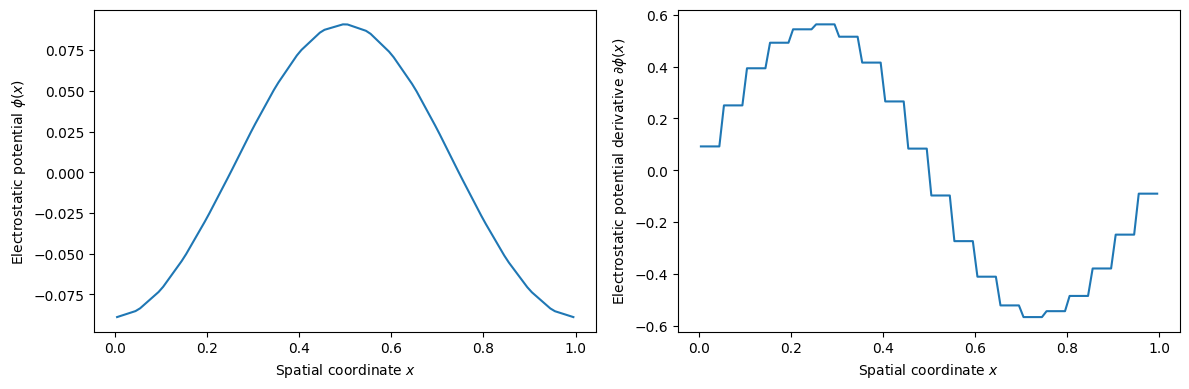

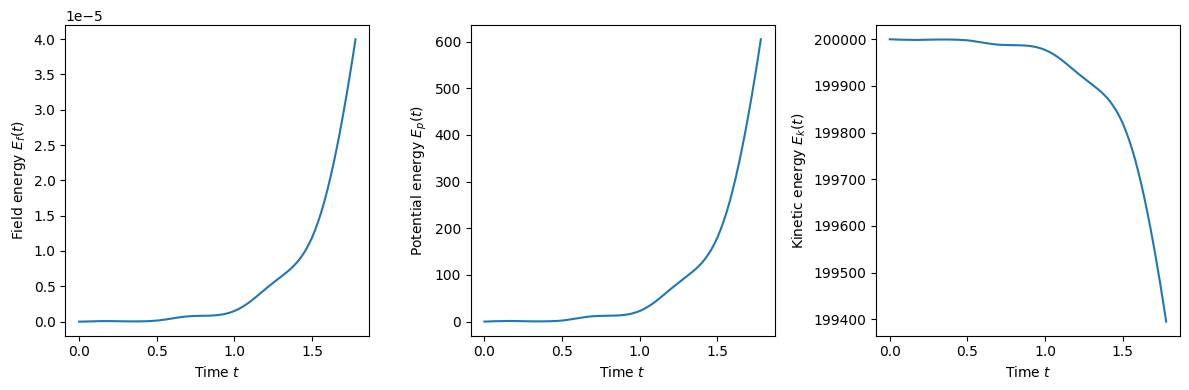

CPU times: user 880 ms, sys: 648 ms, total: 1.53 s
Wall time: 1min 29s


In [10]:
%%time
outputs = model()
with autoclosing_subplots_with_tight_layout(1, 2, figsize=(12, 4), dpi=100) as (fig, axes):
    plot_line_field(axes, outputs, label="Test")
with autoclosing_subplots_with_tight_layout(1, 3, figsize=(12, 4), sharex=True, dpi=100) as (fig, axes):
    plot_energy_trajectories(axes, outputs)

We can also pass keyword arguments when calling the `model` object to override the default values of the parameters specified in the session configuration file. For example:

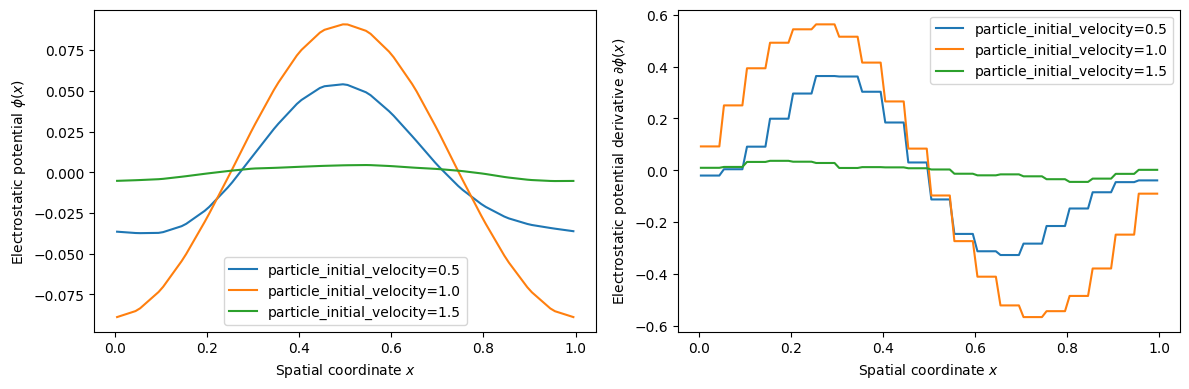

In [11]:
with autoclosing_subplots_with_tight_layout(1, 2, figsize=(12, 4), dpi=100) as (fig, axes):
    for particle_initial_velocity in (0.5, 1., 1.5):
        outputs = model(particle_initial_velocity=particle_initial_velocity)
        plot_line_field(axes, outputs, label=f"{particle_initial_velocity=}")
    for ax in axes:
        ax.legend()